# Importação de Bibliotecas

In [73]:
from statistics import median

import numpy as np
import pandas as pd
import yfinance as yf
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.graph_objects as go

from statsmodels.tsa.arima_model import ARMAResults 
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error, mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from scipy.stats import shapiro, boxcox, probplot, norm
from arch import arch_model

import mplfinance as fplt

A ação escolhida é da AMBEV, porém outras podem ser analisadas ao escolher o código da ação desejada. No caso o da AMBEV é a ABEV3.SA

In [30]:
acao_ambev = yf.Ticker("ABEV3.SA")

É definido um conjunto de teste e outro de treino, onde as datas para treino serão após o início da pandemia (primeiro de abril) com término no começo de 2022, e a data de teste após essa data até o início do mês de julho.

In [31]:
data_ambev = acao_ambev.history(start="2020-04-01", end="2022-04-01", interval="1wk")

data_ambev.reset_index(level=0, inplace=True)

# Exploração dos Dados

In [32]:
data_ambev

,Date,Open,High,Low,Close,Volume,Dividends,Stock Splits
0,2020-03-30,10.825116,11.422363,10.414507,10.629144,66092600.0,0.0,0
1,2020-04-06,11.198396,12.103600,10.899773,11.291717,103344500.0,0.0,0
2,2020-04-13,11.301047,11.748984,10.638476,10.825116,116952300.0,0.0,0
3,2020-04-20,10.638475,11.058416,9.966572,10.367847,119386000.0,0.0,0
4,2020-04-27,10.591816,11.366372,10.498496,10.582484,116581200.0,0.0,0
...,...,...,...,...,...,...,...,...
103,2022-02-28,15.200000,15.200000,13.820000,13.930000,101573100.0,0.0,0
104,2022-03-07,13.790000,14.000000,13.060000,13.180000,172693400.0,0.0,0
105,2022-03-14,13.220000,14.250000,13.160000,14.250000,149107600.0,0.0,0
106,2022-03-21,14.060000,14.500000,13.950000,14.320000,115895000.0,0.0,0


In [33]:
data_ambev.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 108 entries, 0 to 107
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   Date          108 non-null    datetime64[ns]
 1   Open          105 non-null    float64       
 2   High          105 non-null    float64       
 3   Low           105 non-null    float64       
 4   Close         105 non-null    float64       
 5   Volume        105 non-null    float64       
 6   Dividends     108 non-null    float64       
 7   Stock Splits  108 non-null    int64         
dtypes: datetime64[ns](1), float64(6), int64(1)
memory usage: 6.9 KB


In [34]:
data_ambev.isna().sum()

Date            0
Open            3
High            3
Low             3
Close           3
Volume          3
Dividends       0
Stock Splits    0
dtype: int64

<AxesSubplot:xlabel='Date', ylabel='Open'>

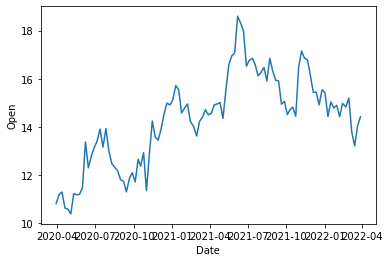

In [35]:
data_ambev.dropna(inplace=True)

sns.lineplot(data=data_ambev, x="Date", y="Open")

## Decomposição

Toda série temporal pode ser decomposta em 3 partes: tendência, sazonalidade e resíduo, que é o que resta após retirar da série as duas primeiras partes, abaixo a separação dessas partes:

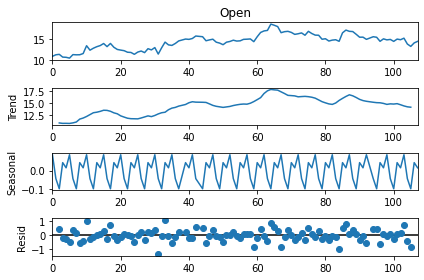

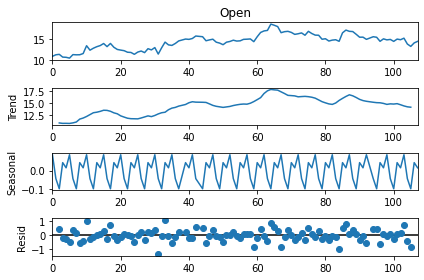

In [36]:
decompose_result_mult = seasonal_decompose(data_ambev["Open"], model="additive", period=5)

trend = decompose_result_mult.trend
seasonal = decompose_result_mult.seasonal
residual = decompose_result_mult.resid

decompose_result_mult.plot()

Claramente a série tem uma tendência de alta, além de apresentar uma sazonalidade.

## Teste Dickey Fuller

Primeiramente vamos usar o teste de Dickey Fuller, usarei o valor P base de 5%, ou seja, caso o valor P esteja abaixo desses 5% significa que a série é estatisticamente estacionária e podemos rejeitar a hipótese nula de que ela não seja, e caso for acima não podemos rejeitar ela.

In [37]:
X = data_ambev["Open"].values

result = adfuller(X)

print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')

for key, value in result[4].items():
	print('\t%s: %.3f' % (key, value))

ADF Statistic: -2.311972
p-value: 0.168136
Critical Values:
	1%: -3.495
	5%: -2.890
	10%: -2.582


Neste caso o teste de Dickey Fuller indicou que a série não é estacionária (Valor P de 16% e os valores críticos de 1%, 5% e 10% são menores que o teste estatístico), aceitamos a hipótese nula por enquanto.

## Diferenciação

A função de diferenciação é criada, onde ela vai  remover os sinais de tendências e reduzir a variância, ela simplesmente é a diferença do valor do período T com o valor do período anterior T-1.

In [38]:
def difference(dataset, interval=1):

	diff = list()

	for i in range(interval, len(dataset)):
		
		value = dataset[i] - dataset[i - interval]
		diff.append(value)

	return pd.Series(diff)

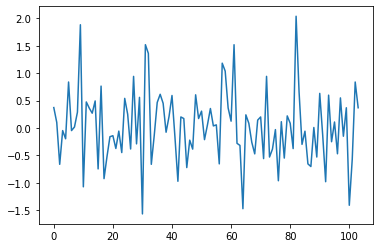

In [39]:
X = data_ambev["Open"].values
data_diferenciada = difference(X)
plt.plot(data_diferenciada)
plt.show()

Com a diferenciação realizada podemos ver no gráfico acima como a série está estabilizada e já pode ser considerada estacionária, mas confirmamos com o teste novamente de ADF.

### Confirmação com ADFuller

In [40]:
result = adfuller(data_diferenciada)

print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')

for key, value in result[4].items():
	
	print('\t%s: %.3f' % (key, value))

ADF Statistic: -11.553431
p-value: 0.000000
Critical Values:
	1%: -3.495
	5%: -2.890
	10%: -2.582


Neste caso confirmamos que a série está estácionária, o valor P está zerado e se formos comparar, o valor do teste estatístico está muito abaixo dos valores críticos.

Normalmente só é necessário uma diferenciação para transformar uma série em estacionária, mas caso seja necessário, pode-se aplicar uma segunda diferenciação, neste caso a diferenciação será sobre a primeira diferenciação (dificilmente haverá casos com mais do que 2 diferenciações).

Abaixo vamos realizar o teste de normalidade por meio do Saphiro-Wilk, que avalia uma amostra de dados e quantifica a probabilidade de os dados terem sido extraídos de uma distribuição gaussiana (distribuição normal).

## Saphiro-Wilk

In [41]:
shapiro(data_diferenciada)

ShapiroResult(statistic=0.9828945398330688, pvalue=0.2003587782382965)

Como o teste estatístico deu 0.98 e seu p-value correspondende 0.20, como o p-value é maior que 0.05, então temos certeza que podemos rejeitar a hipótese nula de que os dados não vem de uma distribuição normal.

Caso o resultado obtido para o valor p fosse abaixo de 0.05, teríamos que utilizar outro método para manter uma distribuição normal. Para resolver isso utilizamos por exemplo a transformação Box-Cox, onde busca-se o melhor valor de lambda que transforme a série para que fique com uma distribuição mais próxima de uma distribuição normal gaussiana, porém como é necessário que o Box-Cox contenha apenas valores positivos, precisamos primeiro normalizar esses valores.

## Transformação Box-Cox

In [42]:
scaler = MinMaxScaler(feature_range=(0.001, 10))
normalizados = scaler.fit_transform([[x] for x in data_diferenciada])

In [43]:
normalizados = normalizados.ravel()

Text(0.5, 1.0, 'Probplot sem distruibuição normal')

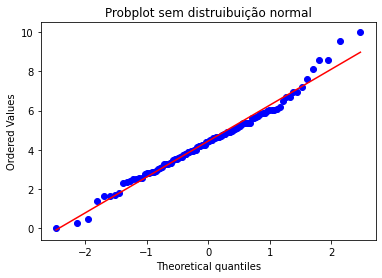

In [44]:
fig = plt.figure()
ax1 = fig.add_subplot()
prob = probplot(normalizados, dist=norm, plot=ax1)
ax1.set_title('Probplot sem distruibuição normal')

Text(0.5, 1.0, 'Probplot depois da transformação de Box-Cox')

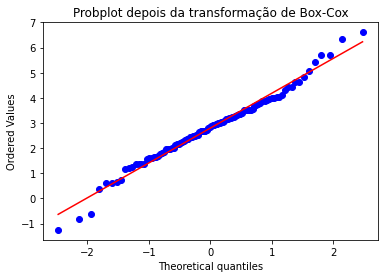

In [45]:
fig = plt.figure()
ax2 = fig.add_subplot()
teste_boxcox, _ = boxcox(normalizados)
prob = probplot(teste_boxcox, dist=norm, plot=ax2)
ax2.set_title('Probplot depois da transformação de Box-Cox')

In [46]:
data_normalizada = pd.Series(normalizados)

In [47]:
data_boxcox = pd.Series(teste_boxcox)

Ao realizar a transformação de Box-Cox é possível ver uma distribuição mais retilínea e esparsa de seus dados, atribuindo assim a distribuição normal dos dados.

Podemos realizar o teste de Shapiro novamente para verificar o seu valor p.

In [48]:
shapiro(data_boxcox)

ShapiroResult(statistic=0.9852392077445984, pvalue=0.30411556363105774)

Nesse caso o valor p aumentou para 30,4%, o que significa que seus dados estão mais distribuídos normalmente. Podemos manter esse resultado para as análises seguintes.

## Médias Móveis

É realizado inicialmente o estudo de médias móveis, onde suavizamos o ruído ou dados com lacunas através de uma projeção futura baseada no valor das janelas escolhidas. Essa janela rolante de um modelo de série temporal avalia:

* A estabilidade do modelo ao longo do tempo. Uma suposição comum do modelo de série temporal é que os coeficientes são constantes em relação ao tempo. Verificar a instabilidade equivale a examinar se os coeficientes são invariantes no tempo.

* A precisão da previsão do modelo.

O tamanho da janela de rolagem dependerá do tamanho da amostra e da periodicidade dos dados. Em geral, podemos usar um tamanho de janela rolante curto para dados coletados em intervalos curtos e um tamanho maior para dados coletados em intervalos mais longos. Tamanhos de janela de rolagem mais longos tendem a gerar estimativas de janela de rolagem mais suaves do que tamanhos mais curtos. Escolhemos o rolling com um período 48 (a cada 48 amostras uma janela avança para o dado seguinte enquanto o último dado é removido da análise), pois estamos analisando a cotação semanalmente.

<AxesSubplot:xlabel='Date'>

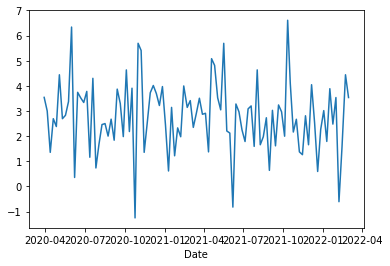

In [49]:
sns.lineplot(data=data_ambev, x="Date", y=data_boxcox)

<AxesSubplot:xlabel='Date'>

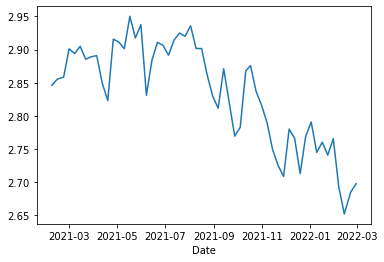

In [50]:
media_movel_open = data_boxcox.rolling(window=48).mean()

sns.lineplot(data=data_ambev, x="Date", y=media_movel_open)

Temos uma tendência decrescente ao realizar as médias móveis, confirmamos isso abaixo ao realizar a média dos valores dos dados e após isso retiramos a tendência da série para que possa ser estudada sem esse fator.

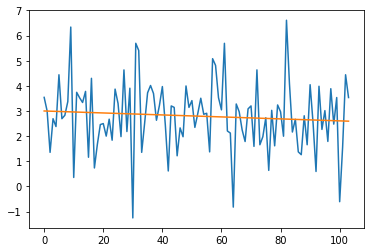

In [51]:
X = [i for i in range(0, len(data_boxcox))]
X = np.reshape(X, (len(X), 1))
y = data_boxcox.values
model = LinearRegression()
model.fit(X, y)

trend = model.predict(X)

plt.plot(y)
plt.plot(trend)
plt.show()

## ACF e PACF

Para ter a previsibilidade, uma série com uma única variável deve ser auto correlacionada, ou seja, o período atual deve ter explicação com base em um período anterior (lag), porém essa característica de auto correlação é de uma série não estacionária. Como já realizamos a transformação para uma série estacionária então utilizaremos a auto correlação parcial, onde o efeito do lag anterior sobre o período atual é removido e só resta o efeito do lag analisado sobre o período atual, exemplo: a auto correlação parcial do quarto lag irá remover o efeito do primeiro, segundo e terceiro lag.

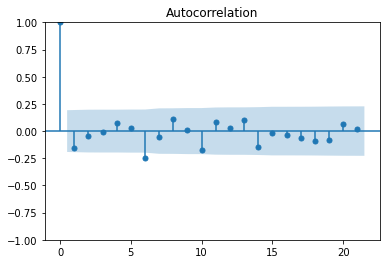

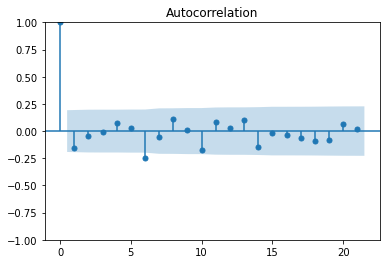

In [52]:
plot_acf(data_boxcox)

c:\Users\Mayara Lopes\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


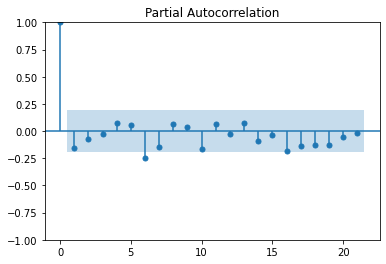

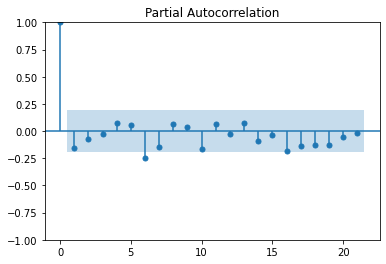

In [53]:
plot_pacf(data_boxcox)


O gráfico de auto correlação mostra que a série tem correlação significativa somente no primeiro lag da auto correlação, e um significativo no gráfico de auto correlação parcial.

Podemos iniciar a criação do modelo de previsão com os dados que foram tratados até o momento.

# Criação, Treinamento e Validação

## ARIMA

In [54]:
dado_treino = data_boxcox[:92]
dado_teste = data_boxcox[92:]

c:\Users\Mayara Lopes\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for ARMA and trend. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
c:\Users\Mayara Lopes\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


<AxesSubplot:ylabel='predicted_mean'>

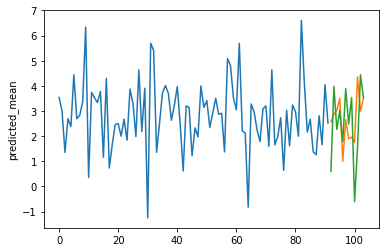

In [55]:
# valores de p, d, q relativos aos valores de:
# p -> quantidade de lags na realização do pac
# d -> quantidade de vezes que foi feita a diferenciação dos dados
# q -> quantia de janelas rolantes escolhidas na realização das médias móveis
modelo = ARIMA(dado_treino, order=[1, 1, 42])

resultado = modelo.fit().forecast(12)

sns.lineplot(data=dado_treino)
sns.lineplot(data=resultado)
sns.lineplot(data=dado_teste)

A representação das cores do gráfico é feita da seguinte forma:
- Azul: plotagem dos dados de treino
- Verde: plotagem dos dados de teste
- Laranja: plotagem da previsão

E mais abaixo podemos verificar os dados de teste e previsão plotados juntos para melhor visualização:

<AxesSubplot:ylabel='predicted_mean'>

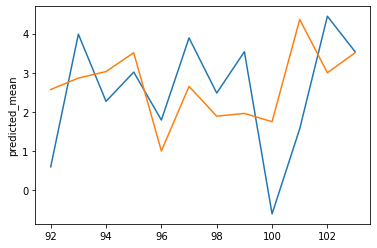

In [56]:
sns.lineplot(data=dado_teste)
sns.lineplot(data=resultado)

# Métricas

As métricas mais comuns utilizadas para julgar o resultado do ARIMA são:

* Mean Absolute Percentage Error (MAPE)
* Correlation between the Actual and the Forecast (corr)
* Min-Max Error (minmax)

In [74]:
mae = mean_absolute_error(dado_teste, resultado) / 10
mape = mean_absolute_percentage_error(dado_teste, resultado) / 10
mse = mean_squared_error(dado_teste, resultado) / 10
rmse = np.sqrt(mean_squared_error(dado_teste, resultado)) / 10

In [75]:
print(f'mae - manual: {mae}')
print(f'mape - manual: {mape}')

print(f'rmse - manual: {rmse}')
print(f'mse - manual: {mse}')

mae - manual: 0.1263322114105535
mape - manual: 0.09613052715648034
rmse - manual: 0.14827991076548447
mse - manual: 0.21986931936620033
